In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statistics import mode
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import logging
from functools import wraps
from time import time
import os

In [2]:
# Configuración del logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def timer_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time()
        result = func(*args, **kwargs)
        end_time = time()
        logging.info(f"Función {func.__name__} ejecutada en {end_time - start_time:.2f} segundos")
        return result
    return wrapper

def log_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        logging.info(f"Ejecutando función: {func.__name__}")
        result = func(*args, **kwargs)
        logging.info(f"Función {func.__name__} completada")
        return result
    return wrapper

In [3]:
class CreditCardDataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    @timer_decorator
    @log_decorator
    def load_data(self):
        """Carga los datos desde el archivo CSV."""
        try:
            self.data = pd.read_csv(self.file_path)
            logging.info(f"Datos cargados exitosamente. Shape: {self.data.shape}")
        except Exception as e:
            logging.error(f"Error al cargar los datos: {str(e)}")
            raise

    @log_decorator
    def show_info(self):
        """Muestra información general sobre el DataFrame."""
        if self.data is None:
            raise ValueError("Los datos no han sido cargados. Ejecute load_data() primero.")
        
        logging.info("Información del DataFrame:")
        self.data.info()

    @log_decorator
    def show_columns(self):
        """Muestra las columnas del DataFrame."""
        if self.data is None:
            raise ValueError("Los datos no han sido cargados. Ejecute load_data() primero.")
        
        logging.info("Columnas del DataFrame:")
        print(self.data.columns.tolist())

    @log_decorator
    def show_null_values(self):
        """Muestra la cantidad de valores nulos por columna."""
        if self.data is None:
            raise ValueError("Los datos no han sido cargados. Ejecute load_data() primero.")
        
        logging.info("Valores nulos por columna:")
        print(self.data.isnull().sum())

    def get_data(self):
        """Retorna el DataFrame cargado."""
        return self.data

In [4]:
# Cargamos los datos

data_loader = CreditCardDataLoader("../data/raw_data/creditcards.csv")
data_loader.load_data()

2024-07-17 23:38:49,204 - INFO - Ejecutando función: load_data
2024-07-17 23:38:49,217 - INFO - Datos cargados exitosamente. Shape: (8950, 18)
2024-07-17 23:38:49,218 - INFO - Función load_data completada
2024-07-17 23:38:49,218 - INFO - Función load_data ejecutada en 0.01 segundos


In [5]:
data_loader.show_info()

2024-07-17 23:38:50,020 - INFO - Ejecutando función: show_info
2024-07-17 23:38:50,020 - INFO - Información del DataFrame:
2024-07-17 23:38:50,025 - INFO - Función show_info completada


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [6]:
data_loader.show_columns()

2024-07-17 23:38:50,570 - INFO - Ejecutando función: show_columns
2024-07-17 23:38:50,570 - INFO - Columnas del DataFrame:
2024-07-17 23:38:50,571 - INFO - Función show_columns completada


['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


In [7]:
data_loader.show_null_values()

2024-07-17 23:38:51,046 - INFO - Ejecutando función: show_null_values
2024-07-17 23:38:51,047 - INFO - Valores nulos por columna:
2024-07-17 23:38:51,048 - INFO - Función show_null_values completada


CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


In [8]:
data = data_loader.get_data()
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [9]:
class NullValueHandler:
    def __init__(self, data):
        self.data = data.copy()
        self.original_dtypes = self.data.dtypes

    @log_decorator
    def show_null_info(self):
        """Muestra información sobre los valores nulos en el DataFrame."""
        null_counts = self.data.isnull().sum()
        null_percentages = 100 * self.data.isnull().sum() / len(self.data)
        null_table = pd.concat([null_counts, null_percentages], axis=1, keys=['Total', 'Porcentaje'])
        print(null_table[null_table['Total'] > 0].sort_values('Total', ascending=False))

    @timer_decorator
    @log_decorator
    def handle_nulls(self, strategy='mean', columns=None):
        """
        Maneja los valores nulos en las columnas especificadas.
        
        :param strategy: Estrategia de imputación ('mean', 'median', 'most_frequent', 'constant')
        :param columns: Lista de columnas a procesar. Si es None, se procesan todas las columnas con nulos.
        """
        if columns is None:
            columns = self.data.columns[self.data.isnull().any()].tolist()

        for column in columns:
            if self.data[column].dtype in ['int64', 'float64']:
                imputer = SimpleImputer(strategy=strategy)
                self.data[column] = imputer.fit_transform(self.data[[column]])
                logging.info(f"Valores nulos en {column} imputados usando {strategy}")
            else:
                logging.warning(f"La columna {column} no es numérica. No se puede aplicar la estrategia {strategy}")

    @log_decorator
    def drop_nulls(self, threshold=None):
        """
        Elimina filas con valores nulos.
        
        :param threshold: Número mínimo de valores no nulos para mantener una fila. Si es None, se eliminan todas las filas con al menos un nulo.
        """
        original_shape = self.data.shape
        self.data.dropna(thresh=threshold, inplace=True)
        logging.info(f"Filas eliminadas: {original_shape[0] - self.data.shape[0]}")

    @log_decorator
    def restore_dtypes(self):
        """Restaura los tipos de datos originales después de la imputación."""
        for column, dtype in self.original_dtypes.items():
            self.data[column] = self.data[column].astype(dtype)
        logging.info("Tipos de datos originales restaurados")

    def get_processed_data(self):
        """Retorna el DataFrame procesado."""
        return self.data

In [10]:
handler = NullValueHandler(data)
handler.show_null_info()

2024-07-17 23:38:52,683 - INFO - Ejecutando función: show_null_info
2024-07-17 23:38:52,686 - INFO - Función show_null_info completada


                  Total  Porcentaje
MINIMUM_PAYMENTS    313    3.497207
CREDIT_LIMIT          1    0.011173


In [11]:
# Manejamos los nulos en CREDIT_LIMIT y MINIMUM_PAYMENTS
handler.handle_nulls(strategy='median', columns=['CREDIT_LIMIT', 'MINIMUM_PAYMENTS'])
    
handler.restore_dtypes()
processed_df = handler.get_processed_data()
    
print("\nInformación de nulos después del procesamiento:")
handler.show_null_info()

2024-07-17 23:38:53,102 - INFO - Ejecutando función: handle_nulls
2024-07-17 23:38:53,105 - INFO - Valores nulos en CREDIT_LIMIT imputados usando median
2024-07-17 23:38:53,108 - INFO - Valores nulos en MINIMUM_PAYMENTS imputados usando median
2024-07-17 23:38:53,108 - INFO - Función handle_nulls completada
2024-07-17 23:38:53,108 - INFO - Función handle_nulls ejecutada en 0.01 segundos
2024-07-17 23:38:53,108 - INFO - Ejecutando función: restore_dtypes
2024-07-17 23:38:53,110 - INFO - Tipos de datos originales restaurados
2024-07-17 23:38:53,110 - INFO - Función restore_dtypes completada
2024-07-17 23:38:53,111 - INFO - Ejecutando función: show_null_info
2024-07-17 23:38:53,113 - INFO - Función show_null_info completada



Información de nulos después del procesamiento:
Empty DataFrame
Columns: [Total, Porcentaje]
Index: []


In [12]:
# Guardamos los datos limpios

processed_df.to_csv("../data/processed_data/creditcards_preprocessed.csv", index=False)

In [13]:
class DataVisualizer:
    def __init__(self, data, output_dir='visualizations'):
        self.data = data
        self.output_dir = output_dir
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
        try:
            plt.style.use('seaborn')
        except:
            logging.warning("El estilo 'seaborn' no está disponible. Se usará el estilo por defecto.")

    def save_figure(self, fig, filename):
        """Guarda la figura en el directorio de salida."""
        filepath = os.path.join(self.output_dir, filename)
        fig.savefig(filepath)
        logging.info(f"Figura guardada en: {filepath}")

    @timer_decorator
    @log_decorator
    def plot_distribution(self, column, bins=30):
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.histplot(self.data[column], bins=bins, kde=True, ax=ax)
        ax.set_title(f'Distribución de {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frecuencia')
        self.save_figure(fig, f'distribution_{column}.png')
        plt.close(fig)

    @timer_decorator
    @log_decorator
    def plot_boxplot(self, column):
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.boxplot(x=self.data[column], ax=ax)
        ax.set_title(f'Boxplot de {column}')
        self.save_figure(fig, f'boxplot_{column}.png')
        plt.close(fig)

    @timer_decorator
    @log_decorator
    def plot_correlation_heatmap(self, columns=None):
        if columns is None:
            columns = self.data.select_dtypes(include=[np.number]).columns
        
        corr = self.data[columns].corr()
        fig, ax = plt.subplots(figsize=(12, 10))
        sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)
        ax.set_title('Mapa de Correlación')
        self.save_figure(fig, 'correlation_heatmap.png')
        plt.close(fig)

    @timer_decorator
    @log_decorator
    def plot_scatter(self, x, y):
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.scatterplot(data=self.data, x=x, y=y, ax=ax)
        ax.set_title(f'Gráfico de dispersión: {x} vs {y}')
        self.save_figure(fig, f'scatter_{x}_vs_{y}.png')
        plt.close(fig)

    @timer_decorator
    @log_decorator
    def plot_pairplot(self, columns=None):
        if columns is None:
            columns = self.data.select_dtypes(include=[np.number]).columns
        
        g = sns.pairplot(self.data[columns])
        g.fig.suptitle('Pairplot de Variables', y=1.02)
        self.save_figure(g.fig, 'pairplot.png')
        plt.close(g.fig)

    @timer_decorator
    @log_decorator
    def plot_categorical_distribution(self, column):
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.countplot(data=self.data, x=column, ax=ax)
        ax.set_title(f'Distribución de {column}')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        self.save_figure(fig, f'categorical_distribution_{column}.png')
        plt.close(fig)

In [14]:
visualizer = DataVisualizer(processed_df)

2024-07-17 23:38:55,083 - WARNING - El estilo 'seaborn' no está disponible. Se usará el estilo por defecto.


In [15]:
# Ejemplos de uso
visualizer.plot_distribution('BALANCE')

2024-07-17 23:38:55,293 - INFO - Ejecutando función: plot_distribution
2024-07-17 23:38:55,422 - INFO - Figura guardada en: visualizations/distribution_BALANCE.png
2024-07-17 23:38:55,423 - INFO - Función plot_distribution completada
2024-07-17 23:38:55,423 - INFO - Función plot_distribution ejecutada en 0.13 segundos


In [16]:
visualizer.plot_boxplot('CREDIT_LIMIT')

2024-07-17 23:38:55,543 - INFO - Ejecutando función: plot_boxplot
2024-07-17 23:38:55,608 - INFO - Figura guardada en: visualizations/boxplot_CREDIT_LIMIT.png
2024-07-17 23:38:55,608 - INFO - Función plot_boxplot completada
2024-07-17 23:38:55,608 - INFO - Función plot_boxplot ejecutada en 0.07 segundos


In [17]:
visualizer.plot_correlation_heatmap()

2024-07-17 23:38:55,717 - INFO - Ejecutando función: plot_correlation_heatmap
2024-07-17 23:38:55,960 - INFO - Figura guardada en: visualizations/correlation_heatmap.png
2024-07-17 23:38:55,961 - INFO - Función plot_correlation_heatmap completada
2024-07-17 23:38:55,961 - INFO - Función plot_correlation_heatmap ejecutada en 0.24 segundos


In [18]:
visualizer.plot_scatter('BALANCE', 'CREDIT_LIMIT')    

2024-07-17 23:38:55,963 - INFO - Ejecutando función: plot_scatter
2024-07-17 23:38:56,046 - INFO - Figura guardada en: visualizations/scatter_BALANCE_vs_CREDIT_LIMIT.png
2024-07-17 23:38:56,046 - INFO - Función plot_scatter completada
2024-07-17 23:38:56,047 - INFO - Función plot_scatter ejecutada en 0.08 segundos


In [19]:
visualizer.plot_pairplot(['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS'])

2024-07-17 23:38:56,050 - INFO - Ejecutando función: plot_pairplot
2024-07-17 23:38:57,412 - INFO - Figura guardada en: visualizations/pairplot.png
2024-07-17 23:38:57,413 - INFO - Función plot_pairplot completada
2024-07-17 23:38:57,413 - INFO - Función plot_pairplot ejecutada en 1.36 segundos


In [20]:
visualizer.plot_categorical_distribution('TENURE')

2024-07-17 23:38:57,416 - INFO - Ejecutando función: plot_categorical_distribution
2024-07-17 23:38:57,426 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-17 23:38:57,430 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/wc/lkhs06_13qdbtd7gv1ffzts80000gn/T/ipykernel_52725/3206700388.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
2024-07-17 23:38:57,488 - INFO - Figura guardada en: visualizations/categorical_distribution_TENURE.png
2024-07-17 23:38:57,488 - INFO - Función plot_categorical_distribution completada
2024-07-17 23:38:5

In [21]:
class CreditCardPreprocessor:
    def __init__(self, data):
        self.data = data.copy()
        self.original_shape = self.data.shape
        self.numeric_columns = self.data.select_dtypes(include=[np.number]).columns.tolist()
        self.numeric_columns.remove('TENURE')  # Asumimos que TENURE no necesita ser normalizado

    def handle_outliers(self, columns=None, method='iqr', threshold=1.5):
        """
        Maneja los outliers en las columnas especificadas.
        
        :param columns: Lista de columnas para manejar outliers. Si es None, se usan todas las columnas numéricas.
        :param method: 'iqr' para rango intercuartil o 'zscore' para puntuación Z.
        :param threshold: Umbral para considerar un valor como outlier.
        """
        if columns is None:
            columns = self.numeric_columns
        
        for column in columns:
            if method == 'iqr':
                Q1 = self.data[column].quantile(0.25)
                Q3 = self.data[column].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - (threshold * IQR)
                upper_bound = Q3 + (threshold * IQR)
                self.data[column] = self.data[column].clip(lower_bound, upper_bound)
            elif method == 'zscore':
                z_scores = np.abs(stats.zscore(self.data[column]))
                self.data[column] = self.data[column].mask(z_scores > threshold, self.data[column].median())
        
        logging.info(f"Outliers manejados en las columnas: {columns}")

    def normalize_variables(self, columns=None):
        """
        Normaliza las variables especificadas usando StandardScaler.
        
        :param columns: Lista de columnas para normalizar. Si es None, se usan todas las columnas numéricas excepto TENURE.
        """
        if columns is None:
            columns = [col for col in self.numeric_columns if col != 'TENURE']
        
        scaler = StandardScaler()
        self.data[columns] = scaler.fit_transform(self.data[columns])
        logging.info(f"Variables normalizadas: {columns}")

    def create_features(self):
        """
        Crea nuevas características basadas en el conocimiento del dominio y los datos existentes.
        """
        # Ratio de compras a límite de crédito
        self.data['PURCHASE_TO_CREDIT_RATIO'] = self.data['PURCHASES'] / self.data['CREDIT_LIMIT']
        
        # Ratio de pagos a compras
        self.data['PAYMENT_TO_PURCHASE_RATIO'] = self.data['PAYMENTS'] / self.data['PURCHASES']
        self.data['PAYMENT_TO_PURCHASE_RATIO'].replace([np.inf, -np.inf], np.nan, inplace=True)
        self.data['PAYMENT_TO_PURCHASE_RATIO'].fillna(0, inplace=True)
        
        # Frecuencia total de compras
        self.data['TOTAL_PURCHASE_FREQUENCY'] = self.data['PURCHASES_FREQUENCY'] + self.data['ONEOFF_PURCHASES_FREQUENCY'] + self.data['PURCHASES_INSTALLMENTS_FREQUENCY']
        
        logging.info("Nuevas características creadas: PURCHASE_TO_CREDIT_RATIO, PAYMENT_TO_PURCHASE_RATIO, TOTAL_PURCHASE_FREQUENCY")

    def preprocess_data(self):
        """
        Aplica todos los pasos de preprocesamiento.
        """
        self.handle_outliers()
        self.normalize_variables()
        self.create_features()
        
        logging.info(f"Preprocesamiento completado. Shape original: {self.original_shape}, Shape nuevo: {self.data.shape}")
        return self.data

In [22]:
# Asumimos que 'df' es tu DataFrame cargado
preprocessor = CreditCardPreprocessor(processed_df)
processed_df = preprocessor.preprocess_data()

2024-07-17 23:38:59,127 - INFO - Outliers manejados en las columnas: ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']
2024-07-17 23:38:59,131 - INFO - Variables normalizadas: ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']
/var/folders/wc/lkhs06_13qdbtd7gv1ffzts80000gn/T/ipykernel_52725/386845333.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The be

In [23]:
processed_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,...,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,PURCHASE_TO_CREDIT_RATIO,PAYMENT_TO_PURCHASE_RATIO,TOTAL_PURCHASE_FREQUENCY
0,C10001,-0.877821,-1.021875,-0.729687,-0.692383,-0.505216,-0.673507,-0.806490,-0.722749,-0.707313,...,-0.697293,-0.737970,-1.010503,-0.899859,-0.784078,-0.629277,12,0.722103,1.233212,-2.236552
1,C10002,1.178546,-0.202708,-0.838160,-0.692383,-0.746029,2.115343,-1.221758,-0.722749,-0.916995,...,0.473089,-0.891333,0.762757,2.165375,0.968887,0.973961,12,-1.098856,-2.583487,-2.861502
2,C10003,0.718487,0.616459,0.040957,0.818320,-0.746029,-0.673507,1.269843,2.210909,-0.916995,...,-0.697293,0.028848,0.910528,-0.569653,0.132544,-0.629277,12,0.044981,-13.908726,2.563757
3,C10004,0.179623,-1.886552,0.866246,2.128108,-0.746029,-0.467401,-1.014125,-0.396788,-0.916995,...,-0.404697,-0.814651,0.910528,-1.058417,-0.459290,-0.629277,12,0.951366,-1.221844,-2.327909
4,C10005,-0.372561,0.616459,-0.819967,-0.661121,-0.746029,-0.673507,-1.014125,-0.396788,-0.916995,...,-0.697293,-0.814651,-0.951394,-0.525443,-0.586234,-0.629277,12,0.861858,0.640809,-2.327909


In [27]:
# 1. Aplicar PCA
class CreditCardPCA:
    def __init__(self, data):
        self.data = data
        self.features = [col for col in data.columns if col not in ['CUST_ID', 'TENURE']]
        self.pca = None
        self.pca_data = None

    def apply_pca(self, n_components=None):
        X = self.data[self.features]
        self.pca = PCA(n_components=n_components)
        self.pca_data = self.pca.fit_transform(X)
        logging.info(f"PCA aplicado. Número de componentes: {self.pca.n_components_}")

    def get_pca_data(self, n_components=None):
        if n_components is None or n_components > self.pca.n_components_:
            n_components = self.pca.n_components_
        
        pca_df = pd.DataFrame(
            self.pca_data[:, :n_components],
            columns=[f'PC{i+1}' for i in range(n_components)]
        )
        pca_df['CUST_ID'] = self.data['CUST_ID']
        pca_df['TENURE'] = self.data['TENURE']
        
        return pca_df

In [28]:
# Aplicar PCA
pca_analyzer = CreditCardPCA(processed_df)
pca_analyzer.apply_pca(n_components=3)  # O el número de componentes que desees
pca_data = pca_analyzer.get_pca_data()

2024-07-17 23:41:26,066 - INFO - PCA aplicado. Número de componentes: 3


In [29]:
class CreditCardClusterPrep:
    def __init__(self, pca_data):
        self.pca_data = pca_data
        self.prepared_data = None
        self.kmeans_results = {}

    def prepare_data(self):
        pc_columns = [col for col in self.pca_data.columns if col.startswith('PC')]
        self.prepared_data = self.pca_data[pc_columns + ['CUST_ID', 'TENURE']]
        logging.info(f"Datos preparados con {len(pc_columns)} componentes principales.")
        return self.prepared_data

    def elbow_method(self, max_clusters=10):
        """
        Implementa el método del codo para K-means.
        """
        inertias = []
        k_values = range(1, max_clusters + 1)
        
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(self.prepared_data.drop(['CUST_ID', 'TENURE'], axis=1))
            inertias.append(kmeans.inertia_)
            self.kmeans_results[k] = kmeans
        
        plt.figure(figsize=(10, 6))
        plt.plot(k_values, inertias, 'bo-')
        plt.xlabel('Número de Clusters (k)')
        plt.ylabel('Inercia')
        plt.title('Método del Codo para K-means')
        plt.show()

    def silhouette_analysis(self, max_clusters=10):
        """
        Calcula y grafica el coeficiente de silueta para diferentes números de clusters.
        """
        silhouette_scores = []
        k_values = range(2, max_clusters + 1)  # Silhouette score no está definido para k=1
        
        for k in k_values:
            kmeans = self.kmeans_results.get(k) or KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(self.prepared_data.drop(['CUST_ID', 'TENURE'], axis=1))
            score = silhouette_score(self.prepared_data.drop(['CUST_ID', 'TENURE'], axis=1), labels)
            silhouette_scores.append(score)
        
        plt.figure(figsize=(10, 6))
        plt.plot(k_values, silhouette_scores, 'bo-')
        plt.xlabel('Número de Clusters (k)')
        plt.ylabel('Coeficiente de Silueta')
        plt.title('Análisis de Silueta para K-means')
        plt.show()

    def recommend_optimal_clusters(self):
        """
        Recomienda un número óptimo de clusters basado en el método del codo y el análisis de silueta.
        """
        # Implementación simple: encuentra el "codo" en la curva de inercia
        inertias = [kmeans.inertia_ for kmeans in self.kmeans_results.values()]
        inertia_changes = np.diff(inertias)
        elbow_point = np.argmin(inertia_changes) + 2  # +2 porque empezamos desde k=1 y queremos el siguiente punto

        # Encuentra el máximo coeficiente de silueta
        silhouette_scores = [silhouette_score(self.prepared_data.drop(['CUST_ID', 'TENURE'], axis=1), 
                                              kmeans.labels_) for k, kmeans in self.kmeans_results.items() if k > 1]
        max_silhouette_point = np.argmax(silhouette_scores) + 2  # +2 porque silhouette empieza desde k=2

        logging.info(f"Método del codo sugiere {elbow_point} clusters")
        logging.info(f"Análisis de silueta sugiere {max_silhouette_point} clusters")
        
        return elbow_point, max_silhouette_point
    
    def get_pca_data(self, n_components=None):
        if n_components is None or n_components > self.pca.n_components_:
            n_components = self.pca.n_components_
        
        pca_df = pd.DataFrame(
            self.pca_data[:, :n_components],
            columns=[f'PC{i+1}' for i in range(n_components)]
        )
        # Añadimos CUST_ID y TENURE después del PCA
        pca_df['CUST_ID'] = self.data['CUST_ID']
        pca_df['TENURE'] = self.data['TENURE']
        
        return pca_df

In [31]:
# Asumimos que 'pca_data' es el DataFrame resultante del análisis PCA:
cluster_prep = CreditCardClusterPrep(pca_data)
cluster_prep.prepare_data()
print(cluster_prep.prepared_data.head())

2024-07-17 23:42:19,854 - INFO - Datos preparados con 3 componentes principales.


         PC1       PC2       PC3 CUST_ID  TENURE
0   0.983467 -0.096554 -2.855234  C10001      12
1  -2.839126 -1.951961 -3.519164  C10002      12
2 -14.165937 -0.552534  2.683639  C10003      12
3  -1.472846  0.175259 -2.196789  C10004      12
4   0.390586  0.042699 -2.917545  C10005      12


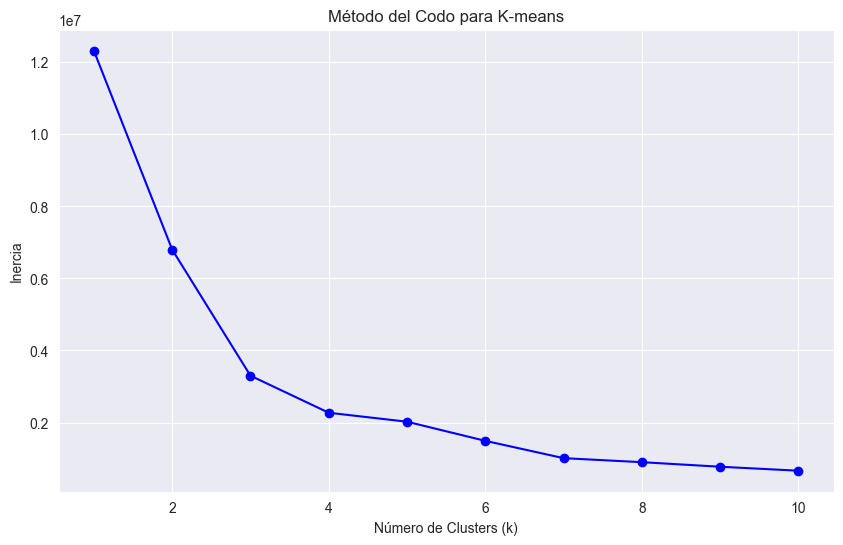

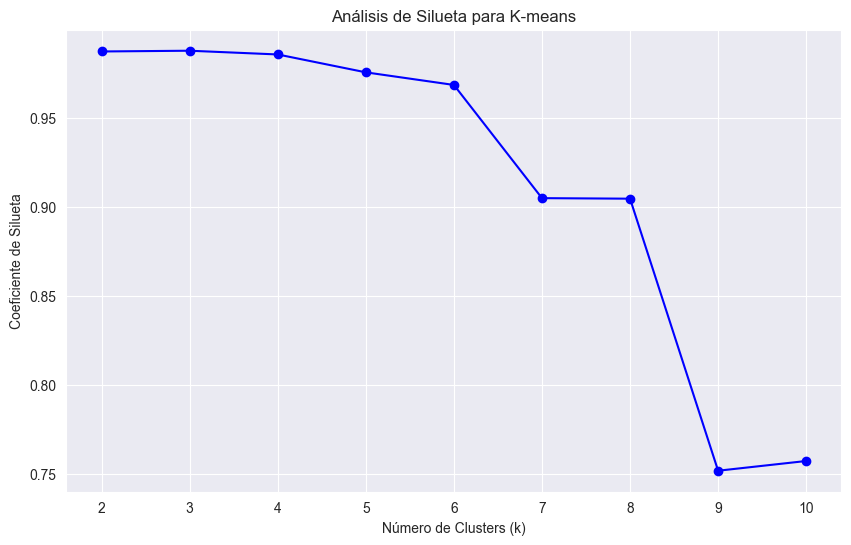

2024-07-17 23:42:44,490 - INFO - Método del codo sugiere 2 clusters
2024-07-17 23:42:44,490 - INFO - Análisis de silueta sugiere 3 clusters


Sugerencia final de número de clusters: entre 2 y 3


In [32]:
cluster_prep.elbow_method()
cluster_prep.silhouette_analysis()

elbow_suggestion, silhouette_suggestion = cluster_prep.recommend_optimal_clusters()
print(f"Sugerencia final de número de clusters: entre {min(elbow_suggestion, silhouette_suggestion)} y {max(elbow_suggestion, silhouette_suggestion)}")

In [55]:
class CreditCardClusterAnalyzer:
    def __init__(self, pca_data, original_data):
        self.pca_data = pca_data
        self.original_data = original_data
        self.cluster_results = {}
        self.silhouette_scores = {}

    def perform_clustering(self, n_clusters_list=[2, 3]):
        for n_clusters in n_clusters_list:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            labels = kmeans.fit_predict(self.pca_data.drop(['CUST_ID', 'TENURE'], axis=1, errors='ignore'))
            self.cluster_results[n_clusters] = labels
            self.silhouette_scores[n_clusters] = silhouette_score(
                self.pca_data.drop(['CUST_ID', 'TENURE'], axis=1, errors='ignore'), labels
            )
            logging.info(f"Clustering realizado con {n_clusters} clusters. "
                         f"Silhouette Score: {self.silhouette_scores[n_clusters]:.4f}")


    def visualize_clusters_2d(self, n_clusters):
        """
        Crea un gráfico de dispersión 2D de los clusters.
        """
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(self.pca_data['PC1'], self.pca_data['PC2'], 
                              c=self.cluster_results[n_clusters], cmap='viridis')
        plt.title(f'Visualización de Clusters ({n_clusters} clusters)')
        plt.xlabel('Primer Componente Principal')
        plt.ylabel('Segundo Componente Principal')
        plt.colorbar(scatter)
        plt.show()

    def visualize_clusters_3d(self, n_clusters):
        """
        Crea un gráfico de dispersión 3D de los clusters.
        """
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(self.pca_data['PC1'], self.pca_data['PC2'], self.pca_data['PC3'],
                             c=self.cluster_results[n_clusters], cmap='viridis')
        ax.set_title(f'Visualización 3D de Clusters ({n_clusters} clusters)')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        plt.colorbar(scatter)
        plt.show()

    def characterize_clusters(self, n_clusters):
        """
        Calcula y muestra estadísticas descriptivas de cada cluster.
        """
        self.pca_data['Cluster'] = self.cluster_results[n_clusters]
        
        numeric_columns = self.pca_data.select_dtypes(include=[np.number]).columns
        
        cluster_stats = self.pca_data.groupby('Cluster')[numeric_columns].agg(['mean', 'median', 'std'])
        print(f"Estadísticas de clusters para {n_clusters} clusters:")
        print(cluster_stats)
        return cluster_stats

    def map_to_original_features(self, n_clusters):
        """
        Mapea los clusters a las características originales.
        """
        self.original_data['Cluster'] = self.cluster_results[n_clusters]
        
        numeric_columns = self.original_data.select_dtypes(include=[np.number]).columns
        
        original_cluster_stats = self.original_data.groupby('Cluster')[numeric_columns].agg(['mean', 'median', 'std'])
        print(f"Estadísticas de características originales para {n_clusters} clusters:")
        print(original_cluster_stats)
        return original_cluster_stats

    def analyze_client_profiles(self, n_clusters):
        """
        Examina las características distintivas de cada cluster y crea perfiles de cliente.
        """
        profiles = {}
        for cluster in range(n_clusters):
            cluster_data = self.original_data[self.original_data['Cluster'] == cluster]
            profile = {
                'size': len(cluster_data),
                'avg_balance': cluster_data['BALANCE'].mean(),
                'avg_purchases': cluster_data['PURCHASES'].mean(),
                'avg_credit_limit': cluster_data['CREDIT_LIMIT'].mean(),
                'common_tenure': cluster_data['TENURE'].mode().values[0]
            }
            profiles[cluster] = profile
            print(f"Perfil del Cluster {cluster}:")
            print(profile)
            print("\n")
        return profiles

    def validate_clustering(self):
        """
        Calcula y muestra métricas de validación para cada solución de clustering.
        """
        for n_clusters, score in self.silhouette_scores.items():
            print(f"Coeficiente de silueta para {n_clusters} clusters: {score:.4f}")

    def interpret_results(self, n_clusters):
        """
        Interpreta los resultados del clustering y sugiere estrategias de negocio.
        """
        profiles = self.analyze_client_profiles(n_clusters)
        for cluster, profile in profiles.items():
            print(f"Interpretación del Cluster {cluster}:")
            if profile['avg_balance'] > self.original_data['BALANCE'].mean():
                print("- Clientes con saldo alto")
            else:
                print("- Clientes con saldo bajo")
            if profile['avg_purchases'] > self.original_data['PURCHASES'].mean():
                print("- Compradores frecuentes")
            else:
                print("- Compradores poco frecuentes")
            print(f"- Límite de crédito promedio: ${profile['avg_credit_limit']:.2f}")
            print(f"- Antigüedad típica: {profile['common_tenure']} meses")
            print("\nEstrategias sugeridas:")
            if profile['avg_purchases'] > self.original_data['PURCHASES'].mean():
                print("- Ofrecer programas de recompensas para mantener la lealtad")
            else:
                print("- Incentivar el uso de la tarjeta con promociones especiales")
            if profile['avg_balance'] > self.original_data['BALANCE'].mean():
                print("- Ofrecer productos de ahorro o inversión")
            else:
                print("- Considerar aumentar el límite de crédito para clientes confiables")
            print("\n")

In [56]:
analyzer = CreditCardClusterAnalyzer(pca_data, processed_df)
analyzer.perform_clustering()

2024-07-17 23:55:45,303 - INFO - Clustering realizado con 2 clusters. Silhouette Score: 0.9874
2024-07-17 23:55:46,044 - INFO - Clustering realizado con 3 clusters. Silhouette Score: 0.9879


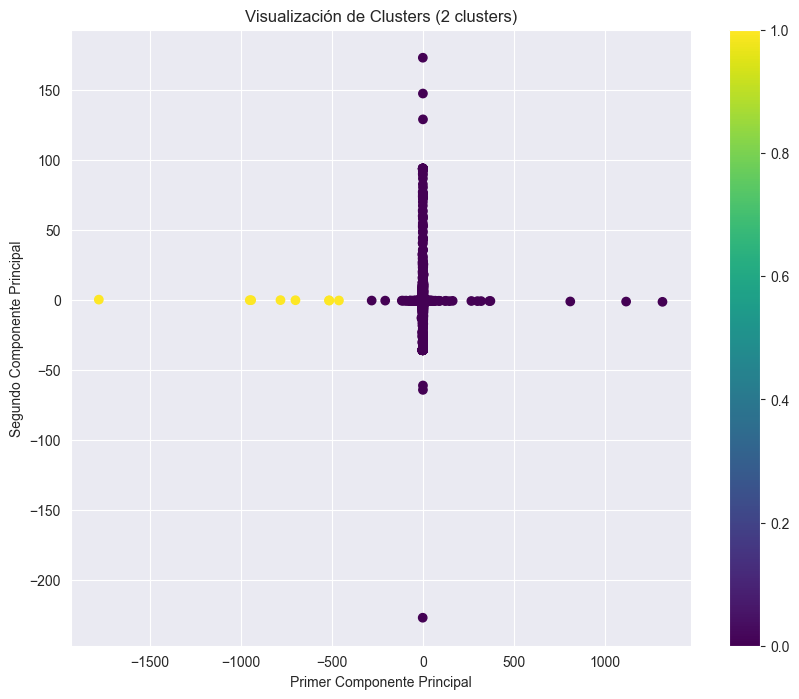

In [57]:
analyzer.visualize_clusters_2d(2)

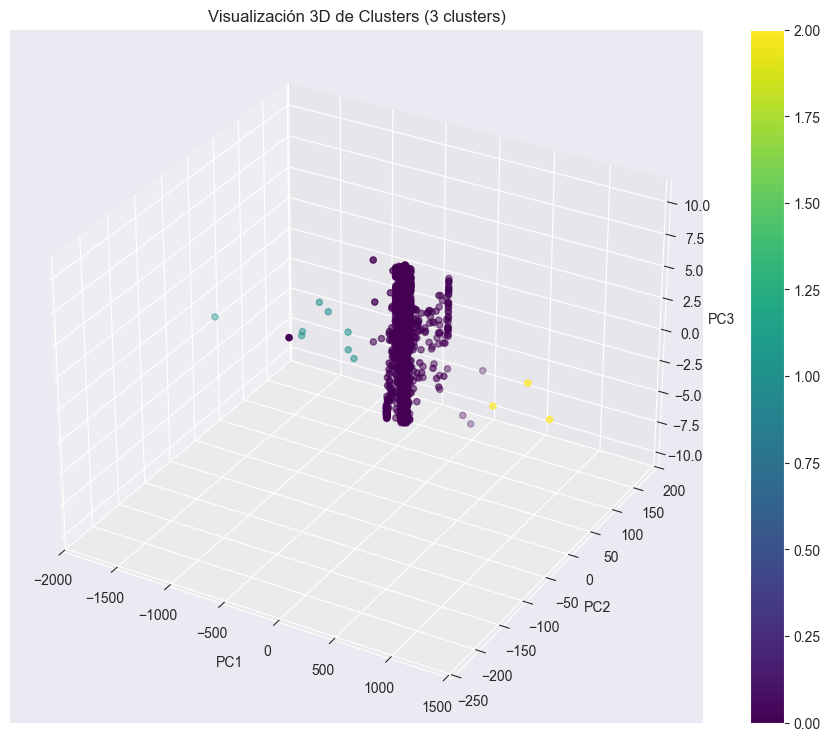

In [58]:
analyzer.visualize_clusters_3d(3)

In [59]:
analyzer.characterize_clusters(2)

Estadísticas de clusters para 2 clusters:
                PC1                               PC2                      \
               mean      median         std      mean    median       std   
Cluster                                                                     
0          0.742730    0.532717   22.810888  0.000227 -0.133737  9.272457   
1       -830.186805 -740.428661  428.081521 -0.254238 -0.241447  0.201814   

              PC3                         TENURE                  Cluster  \
             mean    median       std       mean median       std    mean   
Cluster                                                                     
0       -0.000763 -0.421676  3.292582  11.518117   12.0  1.337080     0.0   
1        0.852443  0.267864  1.390080  10.625000   12.0  2.326094     1.0   

                     
        median  std  
Cluster              
0          0.0  0.0  
1          1.0  0.0  


PC1                               PC2                      \
               mean      median         std      mean    median       std   
Cluster                                                                     
0          0.742730    0.532717   22.810888  0.000227 -0.133737  9.272457   
1       -830.186805 -740.428661  428.081521 -0.254238 -0.241447  0.201814   

              PC3                         TENURE                  Cluster  \
             mean    median       std       mean median       std    mean   
Cluster                                                                     
0       -0.000763 -0.421676  3.292582  11.518117   12.0  1.337080     0.0   
1        0.852443  0.267864  1.390080  10.625000   12.0  2.326094     1.0   

                     
        median  std  
Cluster              
0          0.0  0.0  
1          1.0  0.0

In [60]:
analyzer.map_to_original_features(3)

Estadísticas de características originales para 3 clusters:
          BALANCE                     BALANCE_FREQUENCY                      \
             mean    median       std              mean    median       std   
Cluster                                                                       
0        0.000127 -0.336543  1.000370          0.000804  0.616459  0.999535   
1        0.032901  0.151454  0.743373         -0.504208 -0.134446  1.240837   
2       -0.466596 -0.840931  0.651968         -1.052215 -1.886552  1.445114   

        PURCHASES                     ONEOFF_PURCHASES  ...  \
             mean    median       std             mean  ...   
Cluster                                                 ...   
0        0.000001 -0.428147  1.000671        -0.000243  ...   
1       -0.001111 -0.001023  0.001677         0.163585  ...   
2       -0.000329 -0.000272  0.000951         0.288726  ...   

        PURCHASE_TO_CREDIT_RATIO PAYMENT_TO_PURCHASE_RATIO               \
           

BALANCE                     BALANCE_FREQUENCY                      \
             mean    median       std              mean    median       std   
Cluster                                                                       
0        0.000127 -0.336543  1.000370          0.000804  0.616459  0.999535   
1        0.032901  0.151454  0.743373         -0.504208 -0.134446  1.240837   
2       -0.466596 -0.840931  0.651968         -1.052215 -1.886552  1.445114   

        PURCHASES                     ONEOFF_PURCHASES  ...  \
             mean    median       std             mean  ...   
Cluster                                                 ...   
0        0.000001 -0.428147  1.000671        -0.000243  ...   
1       -0.001111 -0.001023  0.001677         0.163585  ...   
2       -0.000329 -0.000272  0.000951         0.288726  ...   

        PURCHASE_TO_CREDIT_RATIO PAYMENT_TO_PURCHASE_RATIO               \
                             std                      mean       median   
Cluster                                                                   
0                       9.266912                  0.634561     0.785964   
1                       0.018160               -829.930741  -740.171280   
2                       0.001288               1080.876602  1116.555010   

                    TOTAL_PURCHASE_FREQUENCY                     Cluster  \
                std                     mean    median       std    mean   
Cluster                                                                    
0         10.696730                -0.001005 -0.309805  2.452877     0.0   
1        428.081319                 1.438601  1.113416  1.135547     1.0   
2        254.998686                -0.841103 -1.260716  0.885306     2.0   

                     
        median  std  
Cluster              
0          0.0  0.0  
1          1.0  0.0  
2          2.0  0.0  

[3 rows x 63 columns]

In [61]:
analyzer.analyze_client_profiles(2)

Perfil del Cluster 0:
{'size': 8939, 'avg_balance': np.float64(0.00012714858793863552), 'avg_purchases': np.float64(1.1044177651310467e-06), 'avg_credit_limit': np.float64(-2.958757330745483e-06), 'common_tenure': np.int64(12)}


Perfil del Cluster 1:
{'size': 8, 'avg_balance': np.float64(0.032900751743227846), 'avg_purchases': np.float64(-0.0011106828268307198), 'avg_credit_limit': np.float64(0.14211574514611952), 'common_tenure': np.int64(12)}




{0: {'size': 8939,
  'avg_balance': np.float64(0.00012714858793863552),
  'avg_purchases': np.float64(1.1044177651310467e-06),
  'avg_credit_limit': np.float64(-2.958757330745483e-06),
  'common_tenure': np.int64(12)},
 1: {'size': 8,
  'avg_balance': np.float64(0.032900751743227846),
  'avg_purchases': np.float64(-0.0011106828268307198),
  'avg_credit_limit': np.float64(0.14211574514611952),
  'common_tenure': np.int64(12)}}

In [62]:
analyzer.validate_clustering()

Coeficiente de silueta para 2 clusters: 0.9874
Coeficiente de silueta para 3 clusters: 0.9879


In [63]:
analyzer.interpret_results(3)

Perfil del Cluster 0:
{'size': 8939, 'avg_balance': np.float64(0.00012714858793863552), 'avg_purchases': np.float64(1.1044177651310467e-06), 'avg_credit_limit': np.float64(-2.958757330745483e-06), 'common_tenure': np.int64(12)}


Perfil del Cluster 1:
{'size': 8, 'avg_balance': np.float64(0.032900751743227846), 'avg_purchases': np.float64(-0.0011106828268307198), 'avg_credit_limit': np.float64(0.14211574514611952), 'common_tenure': np.int64(12)}


Perfil del Cluster 2:
{'size': 3, 'avg_balance': np.float64(-0.46659574717666247), 'avg_purchases': np.float64(-0.0003289759288632493), 'avg_credit_limit': np.float64(-0.3701592097964073), 'common_tenure': np.int64(12)}


Interpretación del Cluster 0:
- Clientes con saldo alto
- Compradores frecuentes
- Límite de crédito promedio: $-0.00
- Antigüedad típica: 12 meses

Estrategias sugeridas:
- Ofrecer programas de recompensas para mantener la lealtad
- Ofrecer productos de ahorro o inversión


Interpretación del Cluster 1:
- Clientes con saldo

In [64]:
import joblib

# Guardar el modelo PCA
joblib.dump(pca_analyzer.pca, '../models/pca_model.pkl')

['../models/pca_model.pkl']

In [65]:
# Guardar el modelo de K-Means con el número óptimo de clusters
optimal_kmeans_model = KMeans(n_clusters=3, random_state=42)
optimal_kmeans_model.fit(pca_data.drop(['CUST_ID', 'TENURE'], axis=1, errors='ignore'))
joblib.dump(optimal_kmeans_model, '../models/kmeans_model.pkl')

['../models/kmeans_model.pkl']

In [66]:
# Guardar el DataFrame resultante con los clusters asignados
pca_data['Cluster'] = optimal_kmeans_model.labels_
pca_data.to_csv("../data/processed_data/creditcards_clusters.csv", index=False)

logging.info("Modelos y datos guardados exitosamente.")

2024-07-18 00:00:19,968 - INFO - Modelos y datos guardados exitosamente.
